# Modèle d'Analyse des Sentiments basé sur un réseau de neurones

L’objectif de ce TP est de développer un modèle prédictif pour la classification des sentiments des critiques de films (données textuelles) à partir d’un apprentissage automatique par réseau de neurones et d'une représentation en sac de mots (bag of words).

## Collection de données de critiques de films 
Le tp utilisera l'ensemble de données issues de 
[Movie Review Polarity Dataset](https://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz) que vous devez télécharger.

Ce répertoire contient 1000 revues de films, considérées comme positives (répertoire pos) et 1000 autre considérées négatives (répertoire neg). Ces revues sont au format texte.

90% de ces données seront utilisées en tant que données d'entraînement et 10% seront utilisées en données de test.

Ces fichiers textes sont composés de mots importants (tokens), d'espaces, de signes de ponctuations et de mots de liaisons.

---
Si vous utisez colab, vous devez charger le répertoire txt_sentoken de l'archive à la racine de votre Drive Google.

Puis il vous faut monter le répertoir drive pour qu'il soit accessible par colab.
Exécutez le code suivant,  une clé vous sera demandée. Il vous suffit de suivre le lien, de sélectionner votre profile pour obtenir votre clé que vous copierez dans le champs prévu.

In [ ]:
#bloc à exécuter si vous utilisez colab
from google.colab import drive, files

drive.mount('/content/drive')

---
## Préparation des données


### Chargement et nettoyage des données

Il convient pour chaque fichier texte de 
  - identifier les termes (**tokens**) entre espaces,
  - supprimer toute ponctuation,
  - supprimer tous les mots qui ne sont pas uniquement composés de caractères alphabétiques,
  - supprimer tous les mots reconnus en tant que mots vides (stop words) (mots de liaison)
  - supprimer tous les mots dont la longueur est <= 1 caractère.

### Les bibliothèques
La préparation des données implique de pouvoir accéder au système de fichier, ainsi qu'à la bibliothèque nltk et aux bibliothèques spécialisées dans le traitement de texte.. : 

In [1]:
##import pour les fichiers et le traitement de données : 
from os import listdir
import nltk
from nltk.corpus import stopwords
from string import punctuation
from collections import Counter
##import pour les réseaux de neurones : 
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import preprocessing
from numpy import array


In [2]:
# le code suivant charge l'ensemble des mots non importants (en anglais)
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emmanueladam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Fonctions de lectures et d'"épurage" de fichier texte

In [3]:
def load_doc(filename)->str:
    """retourne le texte inclu dans le fichier filename"""
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
def clean_doc(doc)->list:
    """retourne la liste de mots clés inclus dans le texte doc 
    qui ne font pas parti des stop_words"""
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens
 

### Tests de la récupération de mots clés d'un fichier

In [4]:
#rep = '/content/drive/My Drive/txt_sentoken'
rep = '/Users/emmanueladam/Downloads/review_polarity/txt_sentoken'
# mots clés d'un fichier négatif
filename = rep + '/neg/cv007_4992.txt'
text = load_doc(filename)
tokens = clean_doc(text)
print('les 10 premiers mots cles de ', filename)
print(tokens[:10])
# mots clés d'un fichier positif
filename = rep + '/pos/cv994_12270.txt'
text = load_doc(filename)
tokens = clean_doc(text)
print('les 10 premiers mots cles de ', filename)
print(tokens[:10])

les 10 premiers mots cles de  /Users/emmanueladam/Downloads/review_polarity/txt_sentoken/neg/cv007_4992.txt
['thats', 'exactly', 'long', 'movie', 'felt', 'werent', 'even', 'nine', 'laughs', 'nine']
les 10 premiers mots cles de  /Users/emmanueladam/Downloads/review_polarity/txt_sentoken/pos/cv994_12270.txt
['thriller', 'set', 'modern', 'day', 'seattle', 'marked', 'marky', 'marks', 'migration', 'good']


### Construire le vocabulaire global

In [5]:
def add_doc_to_vocab(filename, vocab):
    """cumule dans la liste vocab les mots du fichier filename 
    (1 seule occurence par mot dans vocab)"""
    # load doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # update counts
    vocab.update(tokens)

def build_voc(directory, vocab):
    """ajoute au dictionnaire vocab les mots cles des 900 premiers fichiers 
    du repertoire directory"""
    i=0
    # walk through all files in the folder
    for filename in listdir(directory):
        if i>900: break
        # create the absolute filename
        path = directory + '/' + filename
        # add doc to vocab
        add_doc_to_vocab(path, vocab)
        i = i +1

    
# creer un vocabulaire (liste de mots clés associés à leurs occurences)
vocab = Counter()
# ajouter les mots cles des repertoire pos et neg
build_voc(rep + '/pos', vocab)
build_voc(rep + '/neg', vocab)
# afficher le nb de mots cles trouves
print("nb de mots cles trouves dans les repertoires : ", len(vocab))
print("les 10 premiers mots cles du vocabulaire \
(et leur nb d\'apparition dans les exemples)  : \n", end='')
i=0
for (mot,count) in vocab.items(): 
    print(mot,':',count,end=", ")
    i = i+1
    if i>10:break
# afficher les 10 mots cles les plus utilises
print("\nles 10 mots cles les plus utilises : ", vocab.most_common(10))


nb de mots cles trouves dans les repertoires :  44525
les 10 premiers mots cles du vocabulaire (et leur nb d'apparition dans les exemples)  : 
assume : 45, nothing : 717, phrase : 26, perhaps : 414, one : 4966, used : 338, first : 1624, impressions : 6, rumors : 17, hardly : 114, ever : 665, 
les 10 mots cles les plus utilises :  [('film', 7980), ('one', 4966), ('movie', 4938), ('like', 3182), ('even', 2319), ('good', 2116), ('time', 2052), ('story', 1907), ('films', 1878), ('would', 1856)]


In [6]:
# ne garder que les mots clés apparaissant au moins 3 fois
min_occurrence = 3
tokens = [token for (token,count) in vocab.items() if count >= min_occurrence]
print('en otant les mots utilise moins de ', min_occurrence, ' fois,', 
      ' nb de mots cles = ',len(tokens))

en otant les mots utilise moins de  3  fois,  nb de mots cles =  19665


In [7]:
def save_list(lines, filename):
    """sauve les mots de la liste lines dans le fichier filename"""
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w')
    # write text
    file.write(data)
    # close file
    file.close()

# save tokens to a vocabulary file
save_list(tokens, 'vocab.txt')

---
## Représentation en sac de mots

### Convertir les fichiers en listes de mots-clés appartenant au vocabulaire 


In [8]:
def doc_to_line(filename, vocab)->list:
    """retourne la liste des mots cles du fichier filename appartenant au vocabulaire vocab"""
    # load the doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    return ' '.join(tokens)

In [9]:
def process_docs(directory, vocab)->list:
    """retourne deux listes des mots cles du repertoire directory; 
    la 1ere liste represente les 900 premiers fichiers du repertoire, 
    la 2nde represente les 100 derniers"""
    lines_firts = list()
    lines_lasts = list()
    i=1
    # walk through all files in the folder
    for filename in listdir(directory):
        # create the absolute filename
        path = directory + '/' + filename
        # load and clean the doc
        line = doc_to_line(path, vocab)
        if (i<=900): lines_firts.append(line)
        else:lines_lasts.append(line)
        i = i+1
    return (lines_firts,lines_lasts)

In [10]:
# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)
# load training and testing reviews
(positive_lines_train, positive_lines_test) = process_docs(rep+'/pos', vocab)
(negative_lines_train, negative_lines_test) = process_docs(rep+'/neg', vocab)
# summarize what we have
print("nb exemples d'entrainement positifs : ", len(positive_lines_train))
print("nb exemples d'entrainement negatifs : ", len(negative_lines_train))
print("nb exemples de tests positifs : ", len(positive_lines_test))
print("nb exemples de tests negatifs : ", len(negative_lines_test))

nb exemples d'entrainement positifs :  900
nb exemples d'entrainement negatifs :  900
nb exemples de tests positifs :  100
nb exemples de tests negatifs :  100


In [11]:
len(positive_lines_train[0])

2843


### Convertir les listes de mots en vecteur fréquence d'apparition 
#### Créer le sac de mot de l'ensemble d'entrainement

In [12]:
# create the tokenizer
tokenizer = keras.preprocessing.text.Tokenizer()
# build the training doc by alternating positive lines and negative lines
training_doc = [None]*(len(positive_lines_train)+len(negative_lines_train))
#place a positive line at even positions (0,2,....)
training_doc[::2] = positive_lines_train
#place a negative line at odd positions (1,3,....)
training_doc[1::2] = negative_lines_train
# ask to the tokenizer to build the bag of words : a set of (word, frequence of use)*
tokenizer.fit_on_texts(training_doc)
xTrain = tokenizer.texts_to_matrix(training_doc, mode='freq')

In [13]:
print('Xtrain contient ', xTrain.shape[0], ' exemples de ', xTrain.shape[1], ' valeurs')
print('une valeur = fréquence d\'apparition des mots dans le vocabulaire global.')
print('Ainsi, premier exemple d\'entrainement = \n', xTrain[0])

Xtrain contient  1800  exemples de  19663  valeurs
une valeur = fréquence d'apparition des mots dans le vocabulaire global.
Ainsi, premier exemple d'entrainement = 
 [0.         0.00477327 0.01431981 ... 0.         0.         0.        ]


On décide que les exemples positifs correspondent à une sortie 0 et que les exemples négatifs correspondent à la sortie 1 :

In [15]:
#ytrain = suite de (0 (classement pour eval positive),  1 (classements pour éval négative))
yTrain = array([0,1]*(len(positive_lines_train)))

#### Créer le sac de mot de l'ensemble de validation

In [16]:
# build the test doc by alternating positive lines and negative lines
test_Doc = [None]*(len(positive_lines_test)+len(negative_lines_test))
#place a positive line at even positions (0,2,....)
test_Doc[::2] = positive_lines_test
#place a negative line at odd positions (1,3,....)
test_Doc[1::2] = negative_lines_test
# ask to the tokenizer to give the bag of words : a set of (word, frequence of use),
# the words are already kown by the tokenizer*
xTest = tokenizer.texts_to_matrix(test_Doc, mode='freq')
print('Xtest contient ', xTest.shape[0], ' exemples de ', xTest.shape[1], ' valeurs de fréquence.')

Xtest contient  200  exemples de  19663  valeurs de fréquence.


In [17]:
#sortie attendues des exemples de test, ytest = suite de (0, 1)
yTest = array([0,1]*(len(positive_lines_test)))

In [18]:
xTest[0]

array([0.        , 0.0097561 , 0.00487805, ..., 0.        , 0.0097561 ,
       0.03902439])

---
## Modèle de réseau pour l'analyse des sentiments
Le réseau contient en couche d'entrée aurant de neurones que de valeurs retenues

In [19]:
#TODO: donnez le nb de neurones en entrée (= nb de tokens retenus)
n_words = xTrain.shape[1] 

In [29]:
# TODO: définir la structure du réseau
model = Sequential()
model.add(Dense(500, input_shape=(n_words,), activation='elu'))
model.add(Dense(30, activation='elu'))
model.add(Dense(5, activation='elu'))
model.add(Dense(1, activation='sigmoid'))
# compile network 
model.compile(loss='hinge', optimizer='adam',  metrics=['accuracy'])


In [30]:
#TODO tester differents nb de tests (epochs)
history = model.fit(xTrain, yTrain, 
                    validation_data=(xTest, yTest),
                    epochs=20, verbose=2)

Epoch 1/20
57/57 - 2s - loss: 0.9808 - accuracy: 0.5467 - val_loss: 0.8964 - val_accuracy: 0.8350
Epoch 2/20
57/57 - 1s - loss: 0.7121 - accuracy: 0.8856 - val_loss: 0.6773 - val_accuracy: 0.8550
Epoch 3/20
57/57 - 1s - loss: 0.5391 - accuracy: 0.9761 - val_loss: 0.6782 - val_accuracy: 0.8450
Epoch 4/20
57/57 - 1s - loss: 0.5118 - accuracy: 0.9922 - val_loss: 0.6432 - val_accuracy: 0.8900
Epoch 5/20
57/57 - 1s - loss: 0.5061 - accuracy: 0.9967 - val_loss: 0.6373 - val_accuracy: 0.8800
Epoch 6/20
57/57 - 1s - loss: 0.5045 - accuracy: 0.9967 - val_loss: 0.6345 - val_accuracy: 0.8900
Epoch 7/20
57/57 - 1s - loss: 0.5036 - accuracy: 0.9972 - val_loss: 0.6419 - val_accuracy: 0.8600
Epoch 8/20
57/57 - 1s - loss: 0.5026 - accuracy: 0.9983 - val_loss: 0.6362 - val_accuracy: 0.8750
Epoch 9/20
57/57 - 1s - loss: 0.5022 - accuracy: 0.9983 - val_loss: 0.6328 - val_accuracy: 0.8750
Epoch 10/20
57/57 - 1s - loss: 0.5021 - accuracy: 0.9983 - val_loss: 0.6322 - val_accuracy: 0.8800
Epoch 11/20
57/57 -

### Dessiner l'évolution de l'erreur et de la pertinence

In [31]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

#### Tracer l'erreur d'entrainement / l'erreur de validation
- L'erreur d'entrainement et l'erreur de validation doivent suivre des courbes quasi parallèle.
- L'erreur d'entrainement doit être plus faible que l'erreur de validation
    - si les courbes divergent, si la courbe de validation s'éloigne de la courbe d'entrainement, il y a alors un sur-apprentissage (overfitting) trop adapté aux données d'entrainement, sans doute trop poussé (diminuer les epochs?).
    - s'il y a une erreur d'entrainement trop grande, il y a sous-apprentissage

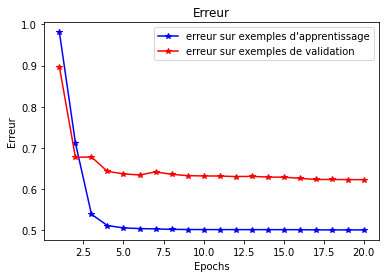

In [32]:
import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, loss, 'b-*', label='erreur sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_loss, 'r-*', label='erreur sur exemples de validation')
plt.title('Erreur')
plt.xlabel('Epochs')
plt.ylabel('Erreur')
plt.legend()

plt.show()

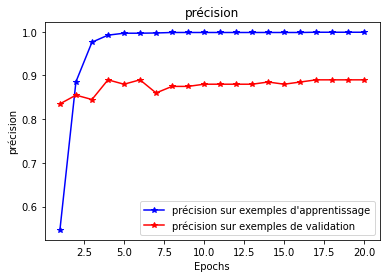

In [33]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, acc, 'b-*', label='précision sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_acc, 'r-*', label='précision sur exemples de validation')
plt.title('précision')
plt.xlabel('Epochs')
plt.ylabel('précision')
plt.legend()

plt.show()

### Evaluer le modèle sur l'exemple d'entrainement

In [34]:
# evaluate
loss, acc = model.evaluate(xTest, yTest, verbose=0)
print('Précision sur exemples de test: %f' % (acc*100))

Précision sur exemples de test: 88.999999


---
## Estimation de nouvelles critiques
Il ne reste plus qu'à utiliser le réseau pour faciliter la classification de futures revues ..  

In [35]:
def predict_sentiment(review, vocab, tokenizer, model):
    """classifie le texte dans la variable 'review' en positif (0) ou negatif (1) """
    # clean
    tokens = clean_doc(review)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    # convert to line
    line = ' '.join(tokens)
    # create the bag of words with the words used in the line
    encoded = tokenizer.texts_to_matrix([line], mode='freq')
    # prediction, output is a vector of (1x1) here (output of the neural network is a vector of 1 element)
    output = model.predict(encoded, verbose=0)
    estimation = round(output[0,0])
    return estimation

In [36]:
# test of a review associated with a note of 10/10
text = 'This movie is the beginning of the culmination of Marvel\'s masterfully woven cinematic universe. Beginning back in 2008 with iron man, we are finally seeing the results of all the movies have been pointing to; and it did not disappoint. Thanos is a complex villain, with deeper and more interesting desires than just "world domination." The dilemmas all the characters face in this movie (both the heroes and the villains) are truly thought provoking and leave you on the edge of your seat. No other set of movies has beeen so involved, so expanded, and encompassed so many story lines/characters and previous movies. The sheer amount of star power alone in this film is insane; and they do a masterful job of weaving all these unique and various characters into a common storyline.'
resultat = predict_sentiment(text, vocab, tokenizer, model)
print('\'',text,'\' ------> est considere comme ', 'positif' if resultat==0 else 'negatif')
print("=-=-=-=-=-=-=-=-=-=-=-=")
# test of a review associated with a note of 1/10
text = 'I was so angry after watching that I had to write something. Boring boring boring, the biggest reason for that is scenario 0/10. It is too long, if I hadn\'t go to cinema and bought ticket there is no way I would have patience to watch it until the end. Everything already seen in previous marvel movies, it seems that every new is even worse with lower quality and I didn\'t even have big expectations before the movie. The main reason I decided to watch it is IMDB rate 9/10 which is total fraud and paid advertisement. There is no guarantee if some character is dead that he will remain dead, everyone could resurrect...Go watch anything else than this. My last marvel movie for sure, so angry that I don\'t watch american movies in cinema any more, all the same, low quality in recent time, just to make many fast, without proper scenario...bull..it'
resultat = predict_sentiment(text, vocab, tokenizer, model)
print('\'',text,'\' ------> est considere comme ', 'positif' if resultat==0 else 'negatif')



' This movie is the beginning of the culmination of Marvel's masterfully woven cinematic universe. Beginning back in 2008 with iron man, we are finally seeing the results of all the movies have been pointing to; and it did not disappoint. Thanos is a complex villain, with deeper and more interesting desires than just "world domination." The dilemmas all the characters face in this movie (both the heroes and the villains) are truly thought provoking and leave you on the edge of your seat. No other set of movies has beeen so involved, so expanded, and encompassed so many story lines/characters and previous movies. The sheer amount of star power alone in this film is insane; and they do a masterful job of weaving all these unique and various characters into a common storyline. ' ------> est considere comme  positif
=-=-=-=-=-=-=-=-=-=-=-=
' I was so angry after watching that I had to write something. Boring boring boring, the biggest reason for that is scenario 0/10. It is too long, if I 

---
---
## TRAVAIL A RENDRE

* Vous devrez tester différentes architectures de réseau, ainsi que différentes configuration (fonctions d'activation, méthodes de correction d'erreur, méthode de calcul de l'erreur, ...)
* Vous enverrez un fichier contenant pour chaque définition de réseau :
    * l'architecture du réseau (un copier coller du bloc 'TODO: définir la structure du réseau')
    * le déroulé de l'apprentissage (un copier coller du bloc résultat de 'TODO tester differents nb de tests (epochs)'
    * le résultat de 'Test Accuracy'

Au minimum 3 différents réseaux devront être fournis